<a href="https://colab.research.google.com/github/IndraP24/Skin-Cancer-Detector/blob/main/sc_detector/notebooks/Skin_Cancer_Classification_Custom_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Skin Cancer Classification



In [1]:
!nvidia-smi

Sat Sep 16 09:18:07 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 457.49       Driver Version: 457.49       CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce MX250      WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   66C    P0    N/A /  N/A |     64MiB /  2048MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import Libraries

In [2]:
#import the important libraries

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import pandas as pd
import datetime
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout, Dense
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

The data is obtained from Kaggle. The data loading from Kaggle is shown below.

There are 7 Classes in that data as follows: 
 
0: Actinic keratoses and intraepithelial carcinoma / Bowen's disease >> `akiec`
 
1: Dermatofibroma >> `df`

2: Benign keratosis-like lesions >> `bkl`

3: Melanoma >> `mel`

4: Melanocytic nevi >> `nv`

5: Vascular lesions >> `vasc`

6: Basal cell carcinoma >> `bcc`


# Loading data using Kaggle API

In [3]:
# Create a directory called ".kaggle"
!mkdir ~/.kaggle

The syntax of the command is incorrect.


In [4]:
# Place the kaggle.json file in the directory
!cp kaggle.json ~/.kaggle/

'cp' is not recognized as an internal or external command,
operable program or batch file.


In [5]:
# Set permissions of 600 ---> which means that the owner has full read and write access to the file, while no other user can access the file
!chmod 600 ~/.kaggle/kaggle.json

'chmod' is not recognized as an internal or external command,
operable program or batch file.


In [6]:
# Search for the ham10000 dataset in kaggle datasets
! kaggle datasets list -s ham10000

'kaggle' is not recognized as an internal or external command,
operable program or batch file.


In [7]:
# Download the ham10000 dataset
! kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

'kaggle' is not recognized as an internal or external command,
operable program or batch file.


In [8]:
# Unzip images and place them in a directory
!mkdir skin-cancer-mnist-ham10000
!unzip /content/skin-cancer-mnist-ham10000.zip -d skin-cancer-mnist-ham10000

'unzip' is not recognized as an internal or external command,
operable program or batch file.


# Reading a specific csv file

In [14]:
df = pd.read_csv('..\data\hmnist_28_28_RGB.csv')
df = df.sample(frac = 1) # randomize the data
data = df.iloc[:,:-1] # extract the pixel data
labels = df.iloc[:,-1:] # extract the corresponding labels
df.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
6117,223,153,172,229,157,176,232,159,180,232,...,211,150,159,209,142,154,205,135,150,4
7233,143,125,135,147,132,146,143,125,134,141,...,148,130,139,148,130,141,149,134,146,4
2406,211,174,189,211,175,187,216,178,192,217,...,212,170,179,211,168,178,207,165,174,5
1835,1,0,1,10,8,9,18,14,16,51,...,183,161,177,179,161,177,173,154,172,6
5163,159,77,90,194,107,128,207,121,146,206,...,196,118,121,192,116,120,187,114,117,4


In [15]:
labels.head(30)

,label
6117,4
7233,4
2406,5
1835,6
5163,4
368,2
5873,4
5030,4
6416,4
5318,4


# Data distribution

[Text(0, 0, 'akiec'),
 Text(1, 0, 'df'),
 Text(2, 0, 'bkl'),
 Text(3, 0, 'mel'),
 Text(4, 0, 'nv'),
 Text(5, 0, 'vasc'),
 Text(6, 0, 'bcc')]

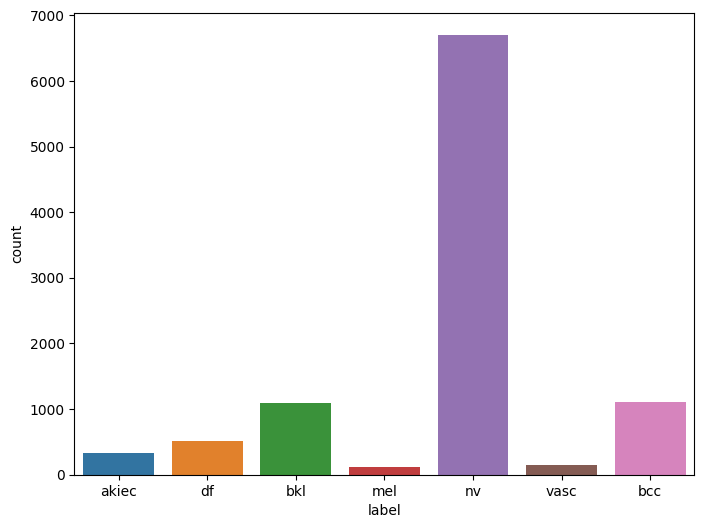

In [16]:
type_of_cancer = ['akiec','df','bkl','mel','nv','vasc','bcc']
counts = list(labels.value_counts())
plt.figure(figsize = (8,6))
ax = sns.countplot(x='label', data=df)
ax.set_xticklabels(type_of_cancer)

The data is heavily imbalanced which leads to a significant effect on the values of metrics

We do the following for resolving the problem:

1. We duplicated the other classes "randomly " other than `nv` class (Data Duplication)


2. Generate new images with 'ImageDataGenarator' from Keras (Data Augmentation)

In [17]:
df = df.sort_values('label') # Sorting the data according to the labels
df = df.reset_index()

In [18]:
df

,index,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,9753,149,118,113,155,123,120,158,123,122,...,152,120,121,145,115,120,138,114,118,0
1,9920,149,126,149,158,135,160,164,141,165,...,156,139,164,146,125,145,139,118,138,0
2,9877,189,141,119,193,140,126,200,131,123,...,182,106,99,154,97,95,84,50,57,0
3,9820,188,158,182,190,161,181,190,163,180,...,146,98,110,137,92,102,127,82,92,0
4,9913,188,146,171,205,165,191,208,169,200,...,198,154,180,199,155,185,199,161,194,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10010,1595,105,89,99,128,114,127,139,122,133,...,149,124,124,142,118,120,126,106,112,6
10011,1625,3,3,2,23,17,16,82,62,61,...,112,80,81,74,51,52,20,14,14,6
10012,1690,21,12,17,46,26,34,85,56,63,...,142,121,131,131,113,132,92,73,93,6
10013,2135,191,168,175,193,168,171,197,171,177,...,159,135,134,157,134,137,150,125,128,6


# Data Duplication

Here we duplicate the class of the data for some amount of times.

The 4th index is ignored as it is the imbalanced class.

In [19]:
index0 = df[df['label'] == 0].index.values
index1 = df[df['label'] == 1].index.values
index2 = df[df['label'] == 2].index.values
index3 = df[df['label'] == 3].index.values
index5 = df[df['label'] == 5].index.values
index6 = df[df['label'] == 6].index.values

In [20]:

df0 = df.iloc[int(min(index0)):int(max(index0)+1)]
df1 = df.iloc[int(min(index1)):int(max(index1)+1)]
df2 = df.iloc[int(min(index2)):int(max(index2)+1)]
df3 = df.iloc[int(min(index3)):int(max(index3)+1)]
df5 = df.iloc[int(min(index5)):int(max(index5)+1)]
df6 = df.iloc[int(min(index6)):int(max(index6)+1)]


We have taken some random optimal values to centralize the new data which contains the duplicated data along with the previous data.

In [21]:

df_index0 = df0.append([df0]*17, ignore_index = True)
df_index1 = df1.append([df1]*15, ignore_index = True)
df_index2 = df2.append([df2]*5, ignore_index = True)
df_index3 = df3.append([df3]*52, ignore_index = True)
df_index5 = df5.append([df5]*45, ignore_index = True)
df_index6 = df6.append([df6]*5, ignore_index = True)

frames = [df, df_index0, df_index1, df_index2, df_index3, df_index5, df_index6]

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_21152\2395392282.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_index0 = df0.append([df0]*17, ignore_index = True)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_21152\2395392282.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_index1 = df1.append([df1]*15, ignore_index = True)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_21152\2395392282.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_index2 = df2.append([df2]*5, ignore_index = True)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_21152\2395392282.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_index3 = df3.append([df3

In [22]:
# Concatenating all the feature dataframes to form the final dataframe
final_df = pd.concat(frames)
final_df.drop('index', inplace = True, axis = 1)
final_df = final_df.sample(frac = 1)
data = final_df.iloc[:,:-1]
labels = final_df.iloc[:,-1:]

### We can now see that The Distribution of The  classes are more Normalized and More Balanced

[Text(0, 0, 'akiec'),
 Text(1, 0, 'df'),
 Text(2, 0, 'bkl'),
 Text(3, 0, 'mel'),
 Text(4, 0, 'nv'),
 Text(5, 0, 'vasc'),
 Text(6, 0, 'bcc')]

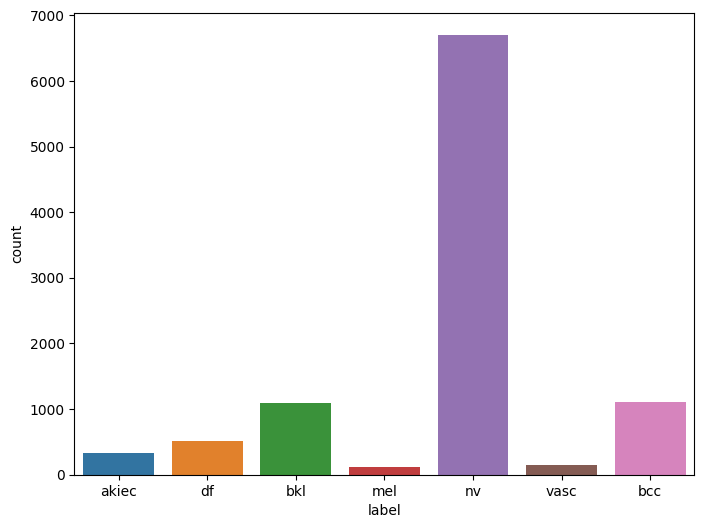

In [23]:
type_of_cancer = ['akiec','df','bkl','mel','nv','vasc','bcc']
counts = list(labels.value_counts())
plt.figure(figsize = (8,6))
ax = sns.countplot(x='label', data=df)
ax.set_xticklabels(type_of_cancer)

# Image data preprocessing

Now we can divide the data. 

X : feature "for the data "

Y : labels "for the lables"





In [24]:
X = np.array(data)
Y = np.array(labels)

## Reshaping the data

In [25]:

X = X.reshape(-1,28,28,3)

print( X.shape)
print( Y.shape)

(50024, 28, 28, 3)
(50024, 1)


## Normalizing the data 

In [26]:
X = (X-np.mean(X))/np.std(X)

## Splitting the data into train and the test data

In [27]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

print( X_train.shape)
print( X_test.shape)
print( Y_train.shape)
print( Y_test.shape)



(40019, 28, 28, 3)
(10005, 28, 28, 3)
(40019, 1)
(10005, 1)


# Data Augmentation with ImageDataGenerator

In [28]:

train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 10,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  shear_range = 0.2,
                                  horizontal_flip = True,
                                  vertical_flip = True,
                                  fill_mode = 'nearest')
train_datagen.fit(X_train)

test_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen.fit(X_test)

train_data = train_datagen.flow(X_train, Y_train, batch_size = 64)
test_data = test_datagen.flow(X_test, Y_test, batch_size = 64)

# Modeling

## Model architecture

In [29]:
model = Sequential([
    
    Conv2D(16, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'),
    Conv2D(32, kernel_size = (3,3), activation = 'relu'),
    MaxPool2D(pool_size = (2,2)),

    Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'),
    Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    MaxPool2D(pool_size = (2,2), padding = 'same'),

    Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same'),
    MaxPool2D(pool_size = (2,2), padding = 'same'),

    Flatten(),
    
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(7, activation='softmax')]
)


### Adjusting learning rate and the optimizer 

In [30]:

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00075,
                                    beta_1 = 0.9,
                                    beta_2 = 0.999,
                                    epsilon = 1e-8)

In [31]:

model.compile(optimizer = optimizer,
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 32)        9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                    

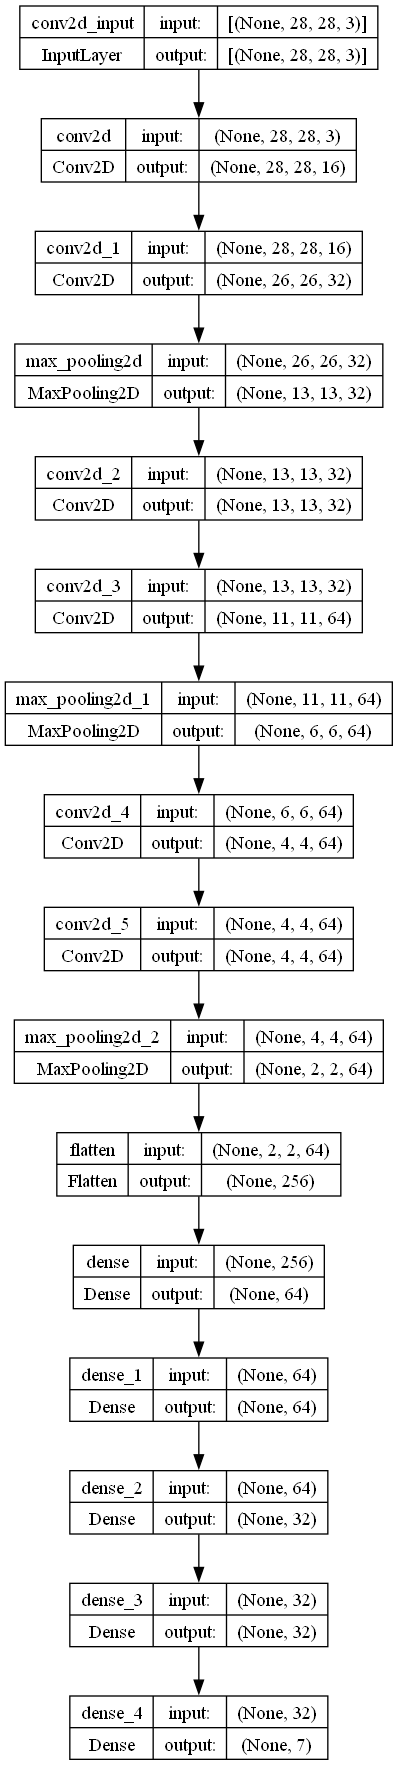

In [33]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Fitting the model

In [34]:
epochs = 20

history = model.fit(X_train,
                    Y_train,
                    validation_split=0.2,
                    batch_size = 64,
                    epochs = epochs,
                    callbacks=[learning_rate_reduction]) 

Epoch 1/20
501/501 [==============================] - 65s 121ms/step - loss: 1.3786 - accuracy: 0.4455 - val_loss: 1.0577 - val_accuracy: 0.5813 - lr: 7.5000e-04
Epoch 2/20
501/501 [==============================] - 62s 124ms/step - loss: 0.9167 - accuracy: 0.6440 - val_loss: 0.7087 - val_accuracy: 0.7243 - lr: 7.5000e-04
Epoch 3/20
501/501 [==============================] - 60s 120ms/step - loss: 0.5814 - accuracy: 0.7817 - val_loss: 0.6003 - val_accuracy: 0.7711 - lr: 7.5000e-04
Epoch 4/20
501/501 [==============================] - 55s 110ms/step - loss: 0.4195 - accuracy: 0.8452 - val_loss: 0.3873 - val_accuracy: 0.8547 - lr: 7.5000e-04
Epoch 5/20
501/501 [==============================] - 59s 118ms/step - loss: 0.3239 - accuracy: 0.8787 - val_loss: 0.2993 - val_accuracy: 0.8892 - lr: 7.5000e-04
Epoch 6/20
501/501 [==============================] - 58s 116ms/step - loss: 0.2511 - accuracy: 0.9062 - val_loss: 0.2914 - val_accuracy: 0.8957 - lr: 7.5000e-04
Epoch 7/20
501/501 [========

# Model Evaluation on test data

In [35]:
model_acc_test = model.evaluate(X_test, Y_test, verbose=0)[1]
print("the test model accuracy =",model_acc_test * 100)

the test model accuracy = 98.22089076042175


# Model Performance measures

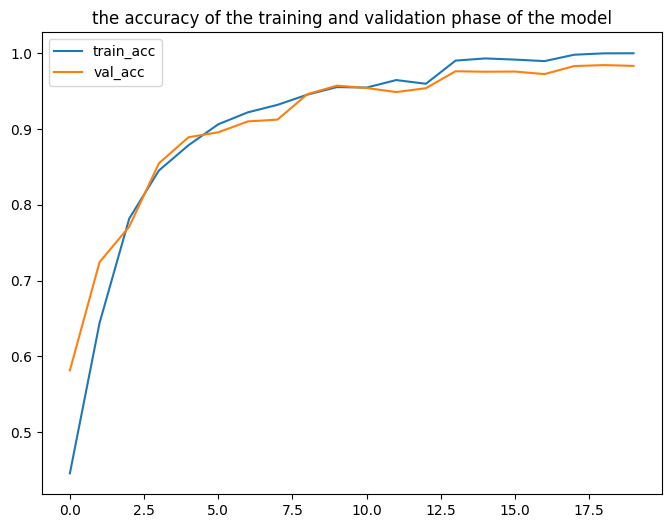

In [36]:
ACC = history.history['accuracy']
VAL_ACC = history.history['val_accuracy']

plt.figure(figsize=(8,6))
plt.title("the accuracy of the training and validation phase of the model")
plt.plot(ACC, label = 'train_acc')
plt.plot(VAL_ACC, label = 'val_acc')
plt.legend()

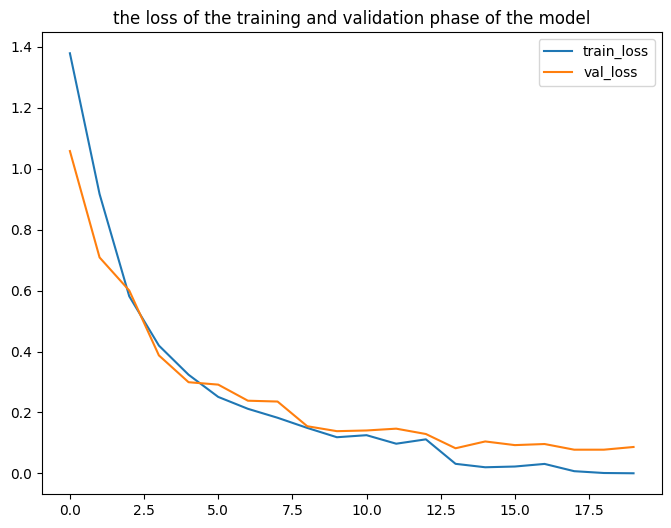

In [37]:
LOSS = history.history['loss']
VAL_LOSS = history.history['val_loss']

plt.figure(figsize=(8,6))
plt.title("the loss of the training and validation phase of the model")
plt.plot(LOSS, label = 'train_loss')
plt.plot(VAL_LOSS, label = 'val_loss')
plt.legend()

## Confusion Matrix

313/313 [==============================] - 5s 15ms/step


<Axes: title={'center': 'the confusion matrix of the model in the train'}>

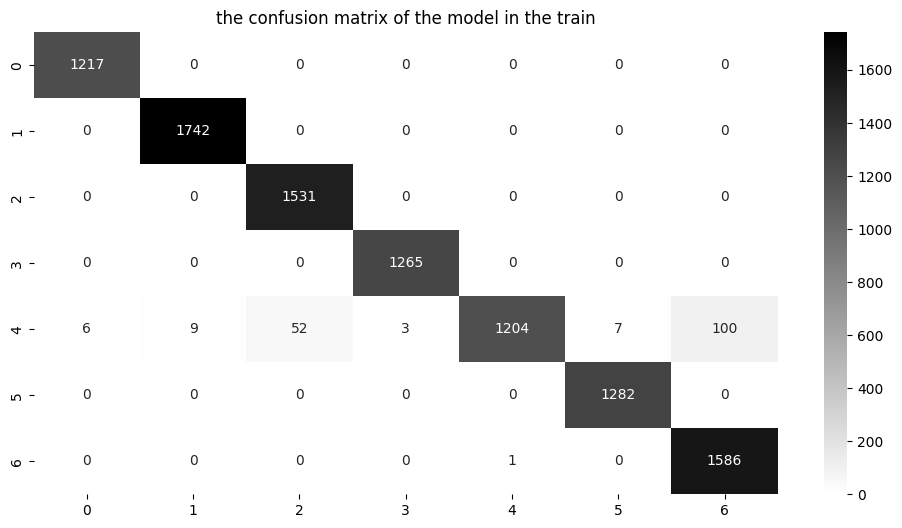

In [38]:

Y_true = np.array(Y_test)

Y_pred = model.predict(X_test)
Y_pred = np.array(list(map(lambda x: np.argmax(x), Y_pred)))

cm1 = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 6))
plt.title('the confusion matrix of the model in the train')
sns.heatmap(cm1, annot = True, fmt = 'g' ,vmin = 0, cmap = 'binary')

# Classification report

- precision

- recall

- f1-score

- accuracy

In [39]:
label_mapping = {
    0: 'nv',
    1: 'mel',
    2: 'bkl',
    3: 'bcc',
    4: 'akiec',
    5: 'vasc',
    6: 'df'
}

classification_report_model = classification_report(Y_true, Y_pred, target_names=label_mapping.values())
print(classification_report_model)

              precision    recall  f1-score   support

          nv       1.00      1.00      1.00      1217
         mel       0.99      1.00      1.00      1742
         bkl       0.97      1.00      0.98      1531
         bcc       1.00      1.00      1.00      1265
       akiec       1.00      0.87      0.93      1381
        vasc       0.99      1.00      1.00      1282
          df       0.94      1.00      0.97      1587

    accuracy                           0.98     10005
   macro avg       0.98      0.98      0.98     10005
weighted avg       0.98      0.98      0.98     10005



# Saving the model for further use

In [40]:
model.save('my_model.h5')

In [44]:
import tensorflow as tf
from PIL import Image
import numpy as np

# Load your pre-trained model
model = tf.keras.models.load_model('my_model.h5')

# Load and preprocess the image
image_path = 'nv_samplepic.jpg'
input_size = (28, 28)  # Adjust the size to match the model's input size
class_names = ['class1', 'class2', 'class3']  # Replace with your actual class names

# Load the image and resize it
img = Image.open(image_path)
img = img.resize(input_size)  # Resize to match the model's input size

# Convert the image to a NumPy array
img_array = np.array(img)

# Preprocess the image (normalize, expand dimensions, etc.)
img_array = img_array / 255.0  # Normalize pixel values
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension if needed

# Make predictions using the model
predictions = model.predict(img_array)

# Get the predicted class index
predicted_class_index = np.argmax(predictions, axis=1)[0]

# Get the predicted class name
predicted_class_name = class_names[predicted_class_index]

# Print the predicted class and confidence
print(f'Predicted class: {predicted_class_name}')
print(f'Confidence: {predictions[0][predicted_class_index]:.2f}')

#predict disease


1/1 [==============================] - 0s 466ms/step
Predicted class: class2
Confidence: 1.00


In [50]:
import tensorflow as tf
from PIL import Image
import numpy as np

def predict_disease(image_path):
    # Load your pre-trained model
    model = tf.keras.models.load_model('my_model.h5')

    # Load and preprocess the image
    input_size = (28, 28)  # Adjust the size to match the model's input size

    # Load the image and resize it
    img = Image.open(image_path)
    img = img.resize(input_size)  # Resize to match the model's input size

    # Convert the image to a NumPy array
    img_array = np.array(img)

    # Preprocess the image (normalize, expand dimensions, etc.)
    img_array = img_array / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension if needed

    # Make predictions using the model
    predictions = model.predict(img_array)


    # Get the confidence score for the prediction
    confidence_score = predictions[0][predicted_class_index]

    return predicted_disease, confidence_score

# Example usage:
image_path = 'melanoma.jpg'
predicted_disease, confidence_score = predict_disease(image_path)
print(f'Predicted Disease: {predicted_disease}')
print(f'Confidence: {confidence_score:.2f}')

1/1 [==============================] - 0s 162ms/step
Predicted Disease: non_melanoma
Confidence: 1.00
